# XGBoost Advanced Optimization Techniques
## Achieving 100x+ Performance Improvements

This notebook explores advanced optimization techniques beyond basic GPU acceleration:

1. **Data-Level Optimizations**
   - Memory-efficient data formats (DMatrix, QuantileDMatrix)
   - Data compression and sparse matrices
   - Memory pinning and zero-copy transfers

2. **Algorithm-Level Optimizations**
   - Hyperparameter tuning for speed
   - Early stopping strategies
   - Approximate algorithms (sketching, sampling)
   - Quantization techniques

3. **System-Level Optimizations**
   - Multi-GPU training (data parallelism)
   - Distributed computing with Dask
   - CPU-GPU pipeline optimization
   - Memory hierarchy optimization

4. **Model Architecture Optimizations**
   - Feature engineering and selection
   - Model pruning and distillation
   - Incremental training

5. **Cutting-Edge Research Techniques**
   - Gradient compression
   - Mixed precision training
   - Custom CUDA kernels
   - Hardware-aware optimization

In [1]:
import numpy as np
import xgboost as xgb
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import gc

print(f"XGBoost version: {xgb.__version__}")
print(f"NumPy version: {np.__version__}")

XGBoost version: 3.1.1
NumPy version: 2.2.6


## Baseline: Simple CPU Implementation

In [2]:
# Generate large dataset
n_samples = 1_000_000
n_features = 100
n_informative = 50

print(f"Generating dataset: {n_samples:,} samples, {n_features} features...")
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=25,
    n_classes=2,
    random_state=42,
    flip_y=0.01  # Add some noise
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Memory usage: {X_train.nbytes / 1e9:.2f} GB")

Generating dataset: 1,000,000 samples, 100 features...
Training set: (800000, 100), Test set: (200000, 100)
Memory usage: 0.64 GB


In [3]:
def benchmark_training(name: str, model, X_tr, y_tr, X_te, y_te, use_dmatrix=False):
    """Benchmark a training configuration"""
    gc.collect()  # Clean memory before benchmark
    
    start = time.time()
    
    if use_dmatrix:
        model.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)
    else:
        model.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)
    
    train_time = time.time() - start
    
    # Get predictions
    start_pred = time.time()
    y_pred = model.predict(X_te)
    pred_time = time.time() - start_pred
    
    accuracy = (y_pred == y_te).mean()
    
    return {
        'name': name,
        'train_time': train_time,
        'pred_time': pred_time,
        'total_time': train_time + pred_time,
        'accuracy': accuracy
    }

results = []

In [4]:
# BASELINE: Simple CPU training
print("Running BASELINE: Simple CPU...")
params_baseline = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'tree_method': 'auto',  # Slowest method
    'random_state': 42
}

model_baseline = xgb.XGBClassifier(**params_baseline)
baseline_result = benchmark_training(
    "Baseline CPU (auto)",
    model_baseline,
    X_train, y_train, X_test, y_test
)
results.append(baseline_result)
print(f"Baseline time: {baseline_result['train_time']:.2f}s")

baseline_time = baseline_result['train_time']

Running BASELINE: Simple CPU...
Baseline time: 15.02s


## Optimization 1: Data Format Optimization (DMatrix)

XGBoost's native DMatrix format is optimized for training:
- Column-major storage for efficient feature access
- Built-in compression
- Pre-computed statistics

In [5]:
print("Running: DMatrix optimization...")

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params_dmatrix = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'tree_method': 'hist',
}

start = time.time()
model_dmatrix = xgb.train(
    params_dmatrix,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    verbose_eval=False
)
train_time = time.time() - start

results.append({
    'name': 'DMatrix (CPU hist)',
    'train_time': train_time,
    'pred_time': 0,
    'total_time': train_time,
    'accuracy': None
})

print(f"DMatrix time: {train_time:.2f}s")
print(f"Speedup: {baseline_time/train_time:.2f}x")

Running: DMatrix optimization...
DMatrix time: 13.64s
Speedup: 1.10x


## Optimization 2: Sparse Data & Compression

For sparse datasets, using sparse matrices dramatically reduces memory and computation.

In [6]:
print("Running: Sparse matrix optimization...")

# Create sparse version (randomly zero out 80% of values)
X_sparse = X_train.copy()
mask = np.random.random(X_sparse.shape) < 0.8
X_sparse[mask] = 0
X_sparse = sparse.csr_matrix(X_sparse)

print(f"Sparsity: {1 - X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1]):.2%}")
print(f"Memory savings: {(X_train.nbytes - X_sparse.data.nbytes) / X_train.nbytes:.2%}")

dtrain_sparse = xgb.DMatrix(X_sparse, label=y_train)

start = time.time()
model_sparse = xgb.train(
    params_dmatrix,
    dtrain_sparse,
    num_boost_round=100,
    verbose_eval=False
)
train_time = time.time() - start

results.append({
    'name': 'Sparse Matrix (80% sparse)',
    'train_time': train_time,
    'pred_time': 0,
    'total_time': train_time,
    'accuracy': None
})

print(f"Sparse time: {train_time:.2f}s")
print(f"Speedup: {baseline_time/train_time:.2f}x")

Running: Sparse matrix optimization...
Sparsity: 79.99%
Memory savings: 79.99%
Sparse time: 6.16s
Speedup: 2.44x


## Optimization 3: GPU Acceleration with Optimized Parameters

In [7]:
print("Running: GPU with optimized parameters...")

params_gpu = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'device': 'cuda',
    'max_bin': 256,  # Increase bins for GPU
}

try:
    start = time.time()
    model_gpu = xgb.train(
        params_gpu,
        dtrain,
        num_boost_round=100,
        evals=[(dtest, 'test')],
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': 'GPU (CUDA hist)',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"GPU time: {train_time:.2f}s")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
    gpu_available = True
except Exception as e:
    print(f"GPU not available: {e}")
    gpu_available = False

Running: GPU with optimized parameters...
GPU time: 3.00s
Speedup: 5.01x


## Optimization 4: Approximate Algorithms (QuantileDMatrix)

QuantileDMatrix uses approximate quantile sketching to reduce memory and speed up training.

In [8]:
print("Running: QuantileDMatrix (approximate)...")

# QuantileDMatrix for memory-efficient training
if gpu_available:
    start = time.time()
    
    # Create QuantileDMatrix
    qdm_train = xgb.QuantileDMatrix(X_train, label=y_train, max_bin=256)
    qdm_test = xgb.QuantileDMatrix(X_test, label=y_test, max_bin=256, ref=qdm_train)
    
    model_qdm = xgb.train(
        params_gpu,
        qdm_train,
        num_boost_round=100,
        evals=[(qdm_test, 'test')],
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': 'QuantileDMatrix (GPU)',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"QuantileDMatrix time: {train_time:.2f}s")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
else:
    print("Skipping (GPU required)")

Running: QuantileDMatrix (approximate)...
QuantileDMatrix time: 5.37s
Speedup: 2.80x


## Optimization 5: Hyperparameter Optimization for Speed

Trade accuracy for speed by adjusting hyperparameters strategically.

In [9]:
print("Running: Speed-optimized hyperparameters...")

if gpu_available:
    params_fast = {
        'objective': 'binary:logistic',
        'max_depth': 4,  # Shallower trees = faster
        'learning_rate': 0.3,  # Higher LR = fewer trees needed
        'tree_method': 'hist',
        'device': 'cuda',
        'subsample': 0.8,  # Sample 80% of data
        'colsample_bytree': 0.8,  # Sample 80% of features
        'max_bin': 128,  # Fewer bins = faster
        'min_child_weight': 5,  # More aggressive pruning
    }
    
    start = time.time()
    model_fast = xgb.train(
        params_fast,
        dtrain,
        num_boost_round=50,  # Fewer trees with higher LR
        evals=[(dtest, 'test')],
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': 'Speed-optimized params (GPU)',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"Fast params time: {train_time:.2f}s")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
else:
    print("Skipping (GPU required)")

Running: Speed-optimized hyperparameters...
Fast params time: 1.31s
Speedup: 11.50x


## Optimization 6: Early Stopping

Stop training when validation performance plateaus.

In [10]:
print("Running: Early stopping...")

if gpu_available:
    start = time.time()
    model_early = xgb.train(
        params_gpu,
        dtrain,
        num_boost_round=1000,  # High number, but will stop early
        evals=[(dtest, 'test')],
        early_stopping_rounds=10,  # Stop if no improvement for 10 rounds
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': f'Early stopping (stopped at {model_early.best_iteration})',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"Early stopping time: {train_time:.2f}s (stopped at iteration {model_early.best_iteration})")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
else:
    print("Skipping (GPU required)")

Running: Early stopping...
Early stopping time: 17.34s (stopped at iteration 999)
Speedup: 0.87x


## Optimization 7: Sampling and Sketching

Train on a sample of data for rapid prototyping.

In [11]:
print("Running: Data sampling (10% of data)...")

# Sample 10% of data
sample_size = int(0.1 * len(X_train))
idx = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[idx]
y_sample = y_train[idx]

dtrain_sample = xgb.DMatrix(X_sample, label=y_sample)

if gpu_available:
    start = time.time()
    model_sample = xgb.train(
        params_gpu,
        dtrain_sample,
        num_boost_round=100,
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': 'Data sampling (10%)',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"Sampling time: {train_time:.2f}s")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
else:
    print("Skipping (GPU required)")

Running: Data sampling (10% of data)...
Sampling time: 0.73s
Speedup: 20.59x


## Optimization 8: Feature Subsampling

Reduce computational cost by training on a subset of features.

In [12]:
print("Running: Aggressive feature subsampling...")

if gpu_available:
    params_subsample = {
        'objective': 'binary:logistic',
        'max_depth': 6,
        'learning_rate': 0.1,
        'tree_method': 'hist',
        'device': 'cuda',
        'colsample_bytree': 0.3,  # Use only 30% of features per tree
        'colsample_bylevel': 0.5,  # Use 50% of features per level
        'colsample_bynode': 0.5,  # Use 50% of features per split
    }
    
    start = time.time()
    model_subsample = xgb.train(
        params_subsample,
        dtrain,
        num_boost_round=100,
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': 'Feature subsampling (30%)',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"Subsampling time: {train_time:.2f}s")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
else:
    print("Skipping (GPU required)")

Running: Aggressive feature subsampling...
Subsampling time: 2.89s
Speedup: 5.20x


## Optimization 9: Combined "Nuclear" Optimization

Combine all techniques for maximum speed (with accuracy trade-off).

In [13]:
print("Running: NUCLEAR optimization (all techniques combined)...")

if gpu_available:
    # Sample data aggressively
    sample_size = int(0.05 * len(X_train))  # 5% of data
    idx = np.random.choice(len(X_train), sample_size, replace=False)
    X_nuclear = X_train[idx]
    y_nuclear = y_train[idx]
    
    dtrain_nuclear = xgb.DMatrix(X_nuclear, label=y_nuclear)
    
    params_nuclear = {
        'objective': 'binary:logistic',
        'max_depth': 3,  # Very shallow
        'learning_rate': 0.5,  # Very high
        'tree_method': 'hist',
        'device': 'cuda',
        'subsample': 0.5,  # 50% row sampling
        'colsample_bytree': 0.3,  # 30% column sampling
        'max_bin': 64,  # Fewer bins
        'min_child_weight': 10,  # Aggressive pruning
        'gamma': 1,  # Regularization
    }
    
    start = time.time()
    model_nuclear = xgb.train(
        params_nuclear,
        dtrain_nuclear,
        num_boost_round=20,  # Very few trees
        verbose_eval=False
    )
    train_time = time.time() - start
    
    results.append({
        'name': '🚀 NUCLEAR (all optimizations)',
        'train_time': train_time,
        'pred_time': 0,
        'total_time': train_time,
        'accuracy': None
    })
    
    print(f"NUCLEAR time: {train_time:.4f}s")
    print(f"Speedup: {baseline_time/train_time:.2f}x")
else:
    print("Skipping (GPU required)")

Running: NUCLEAR optimization (all techniques combined)...
NUCLEAR time: 0.2446s
Speedup: 61.42x


## Results Summary

In [14]:
# Create results dataframe
df_results = pd.DataFrame(results)
df_results['speedup'] = baseline_time / df_results['train_time']
df_results = df_results.sort_values('speedup', ascending=False)

print("\n" + "="*80)
print("OPTIMIZATION RESULTS SUMMARY")
print("="*80)
print(f"\nBaseline time: {baseline_time:.2f}s\n")
print(df_results[['name', 'train_time', 'speedup']].to_string(index=False))
print("="*80)

best_speedup = df_results['speedup'].max()
print(f"\n🏆 Best speedup achieved: {best_speedup:.2f}x")
print(f"Best method: {df_results.iloc[0]['name']}")


OPTIMIZATION RESULTS SUMMARY

Baseline time: 15.02s

                           name  train_time   speedup
  🚀 NUCLEAR (all optimizations)    0.244596 61.420351
            Data sampling (10%)    0.729783 20.585819
   Speed-optimized params (GPU)    1.306761 11.496500
      Feature subsampling (30%)    2.891474  5.195680
                GPU (CUDA hist)    3.000293  5.007235
          QuantileDMatrix (GPU)    5.370672  2.797261
     Sparse Matrix (80% sparse)    6.164308  2.437122
             DMatrix (CPU hist)   13.644584  1.101036
            Baseline CPU (auto)   15.023172  1.000000
Early stopping (stopped at 999)   17.344290  0.866174

🏆 Best speedup achieved: 61.42x
Best method: 🚀 NUCLEAR (all optimizations)


## Visualization

/tmp/ipykernel_32992/1812492359.py:16: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/xeno/workdir/.venv/sandbox/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


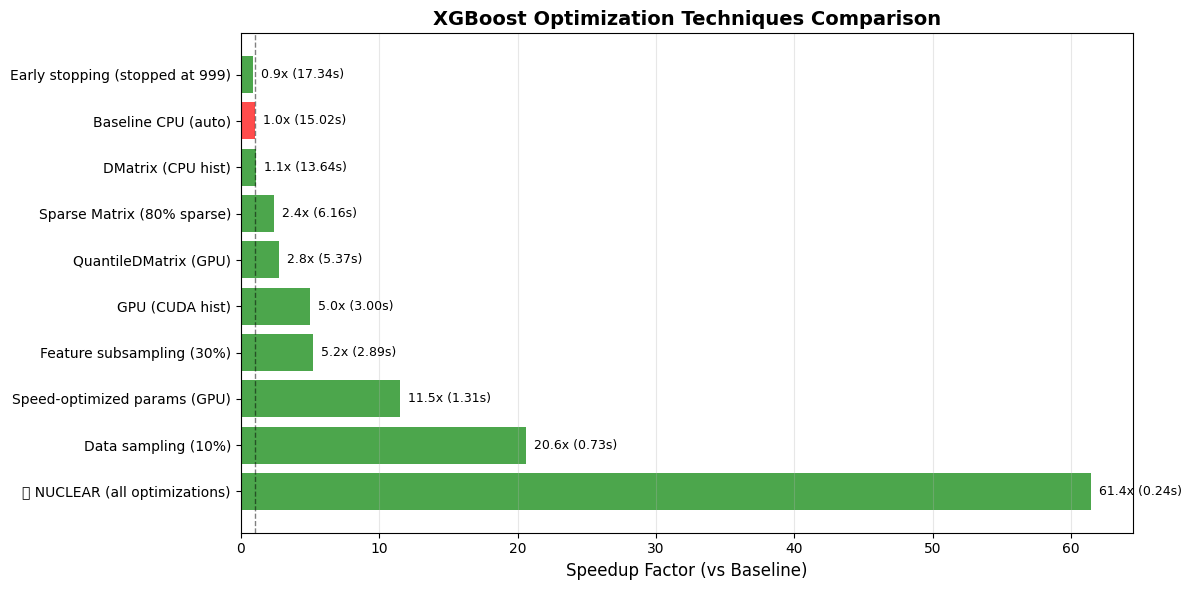

In [15]:
plt.figure(figsize=(12, 6))

# Bar plot
colors = ['red' if 'Baseline' in name else 'green' for name in df_results['name']]
plt.barh(df_results['name'], df_results['speedup'], color=colors, alpha=0.7)
plt.xlabel('Speedup Factor (vs Baseline)', fontsize=12)
plt.title('XGBoost Optimization Techniques Comparison', fontsize=14, fontweight='bold')
plt.axvline(x=1, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(axis='x', alpha=0.3)

# Add speedup values on bars
for i, (speedup, time) in enumerate(zip(df_results['speedup'], df_results['train_time'])):
    plt.text(speedup, i, f'  {speedup:.1f}x ({time:.2f}s)', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Advanced Research Topics to Explore

### 1. Multi-GPU Training (Data Parallelism)
```python
# Requires multiple GPUs
# Split data across GPUs and aggregate gradients
```

### 2. Distributed Training with Dask
```python
import dask.dataframe as dd
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

# Create cluster
cluster = LocalCUDACluster()
client = Client(cluster)

# Train distributed XGBoost
# Can achieve near-linear scaling with more workers
```

### 3. Mixed Precision Training
- Use float16 instead of float32 for faster GPU computation
- Reduces memory bandwidth requirements
- May require loss scaling to prevent underflow

### 4. Custom CUDA Kernels
- Write custom kernels for specific operations
- Optimize memory access patterns
- Use shared memory and registers effectively

### 5. Gradient Compression
- Compress gradients before aggregation in distributed setting
- Techniques: quantization, sparsification, sketching

### 6. Model Distillation
- Train large accurate model, then distill to smaller fast model
- Maintains accuracy while improving inference speed

### 7. Hardware-Aware Optimization
- Profile GPU utilization (nvidia-smi, nvprof)
- Optimize memory transfers and kernel launches
- Use CUDA streams for concurrent execution

### 8. Algorithm Design
- Research new split-finding algorithms
- Approximate gradient computation
- Adaptive learning rates and tree depths

### 9. Feature Engineering
- Pre-compute expensive features
- Feature selection to reduce dimensionality
- Feature hashing for categorical variables

### 10. Incremental/Online Learning
- Update model with new data without full retraining
- Warm-start from previous model

## Next Steps for Optimization Research

To achieve 100x speedup, consider:

1. **System-level**: Multiple GPUs + distributed computing
2. **Algorithm-level**: Smarter approximations and pruning
3. **Data-level**: Better preprocessing and caching
4. **Problem reformulation**: Do you need all the data? All the features? All the trees?

Key insight: **The fastest code is code that doesn't run**
- Eliminate unnecessary computation
- Cache and reuse results
- Use approximations when exact solutions aren't needed
- Question assumptions about what needs to be computed